In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from glow import lenses, time_domain_c, freq_domain_c, wrapper

# Overview

The core of this module is written in C, it can be used in three ways:
  - Directly from C: the syntax, types of 'objects' etc. are similar to the Python version. There are examples in wrapper/glow_lib/tests (not proper examples, since this are just auxiliary test files) 
  - Directly from Python: the wrapper can be used independently from any other of our Python modules (see Testing performance section below). However it is not fully functional since even though most of the algorithms are C based, they are still interfaced through Python.
  - **(Preferred)** Through `time_domain_c.py` and `freq_domain_c.py`: the new objects included here can be used in the same way as the ones in `time_domain.py` and `freq_domain.py`, i.e. they can be interfaced with `lenses.py`. **However** keep in mind that a change in the lenses will either not have any effect or (hopefully) the code will break down. The implementation of the lenses in C and Python are independent and the wrapper only translates the physical parameters from Python to C.
 
Finally, the two sets (`time_domain.py`, `freq_domain.py`) and (`time_domain_c.py`, `freq_domain_c.py`) are totally independent of each other. The first one is written in full Python, while the second one relies on compiled code (C and Cython).

# Time domain

## Single contour

This object performs the exact computation of $I(\tau)$ for an arbitrary lens assuming that there is only one critical point in the Fermat potential (i.e. the minimum). The algorithm tries to find the first two critical points starting from the origin and infinity, and will not proceed if they do not coincide.

By default, $I(\tau)$ is precomputed on a grid and can then be evaluated at any point using an interpolation function (computed internally)

In [2]:
Psi = lenses.Psi_CIS()

# impact parameter
y = 1.4

# parameters for the temporal grid
p_prec = {'tmin' : 1e-3,
          'tmax' : 100,
          'Nt' : 5000}

It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

We can then work with it, either accessing its grid points (`It.t_grid`, `It.It_grid`) or use its interpolation function

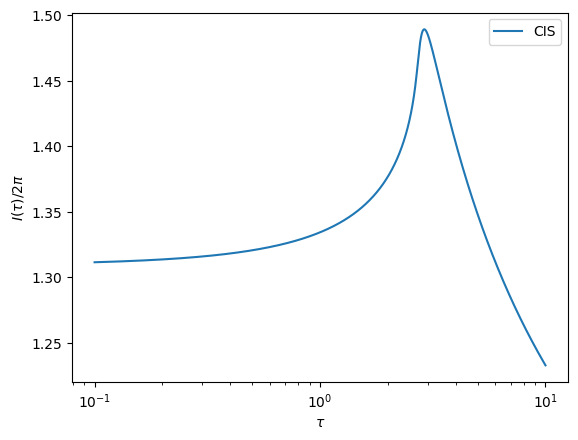

In [3]:
taus = np.geomspace(1e-1, 10, 10000)

fig, ax = plt.subplots()

ax.plot(taus, It(taus)/2/np.pi, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.set_xscale('log')
ax.legend(loc='best');

We can display the precision parameters as shown below. An important option is `parallel` (switched on by default), that allows for the computation to be performed in parallel (with OMP).

In [4]:
It.display_info()

	////////////////////////////
	///   I(t) information   ///
	////////////////////////////

 * Method: single contour (C code)

 * Impact parameter y = 1.4

 * Precision parameters:
   ** Nt = 5000
   ** tmin = 0.001
   ** tmax = 100
   ** eval_mode = interpolate
   ** sampling = log
   ** interp_fill_value = None
   ** interp_kind = linear
   ** oversampling_n = 10
   ** oversampling_tmin = 0.1
   ** oversampling_tmax = 10.0
   ** lens_file_xmin = 1e-07
   ** lens_file_xmax = 10000000.0
   ** lens_file_Nx = 10000
   ** lens_file_fname = wrapper/glow_lib/external/tmp
   ** C_prec = {}
   ** method = standard
   ** parallel = True

 * Lens: CIS



Another important option is `eval_mode = exact` (by default `eval_mode = interpolate`). In this case the grid is not precomputed, and the evaluation of the object computes the integral at any point requested without using interpolation.

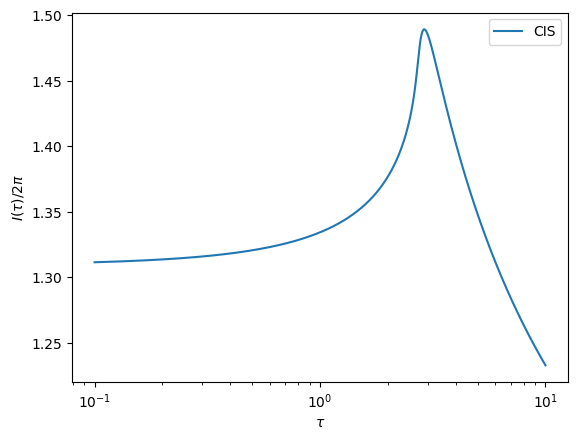

In [5]:
Psi = lenses.Psi_CIS()

y = 1.4
p_prec = {'eval_mode' : 'exact'}

It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

## ---------------------------------------------------

taus = np.geomspace(1e-1, 10, 10000)
Its = It.eval_It(taus)/2/np.pi

fig, ax = plt.subplots()

ax.plot(taus, Its, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.set_xscale('log')
ax.legend(loc='best');

We can also compute the Green function $G(\tau)$

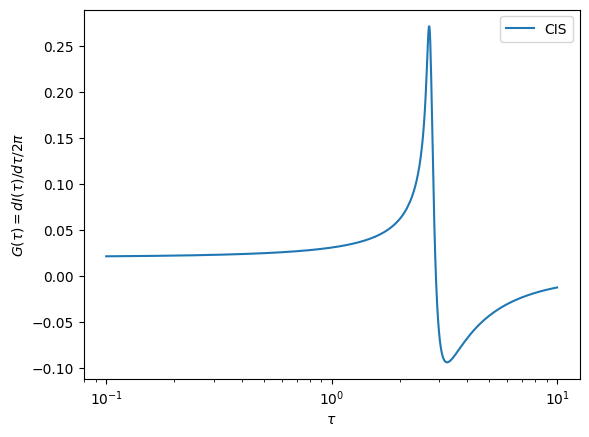

In [6]:
Psi = lenses.Psi_CIS()

y = 1.4
p_prec = {'eval_mode' : 'exact'}

It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

## ---------------------------------------------------

taus = np.geomspace(1e-1, 10, 1000)
Gts = It.eval_Gt(taus, dt=1e-3)  # default value dt=1e-4

fig, ax = plt.subplots()

ax.plot(taus, Gts, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$G(\tau)=dI(\tau)/d\tau/2\pi$')
ax.set_xscale('log')
ax.legend(loc='best');

## Analytic SIS

Implementation of the analytic formula for the SIS in the time domain.

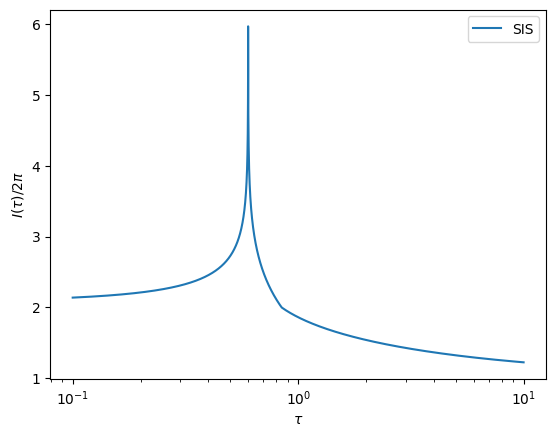

In [7]:
y = 0.3
p_prec = {'eval_mode' : 'exact'}

It_SIS = time_domain_c.It_AnalyticSIS_C(y, p_prec)

## -----------------------------------------------

taus = np.geomspace(1e-1, 10, 10000)
Its = It_SIS(taus)/2/np.pi

fig, ax = plt.subplots()

ax.plot(taus, Its, label='SIS')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.set_xscale('log')
ax.legend(loc='best');

And the Green function is

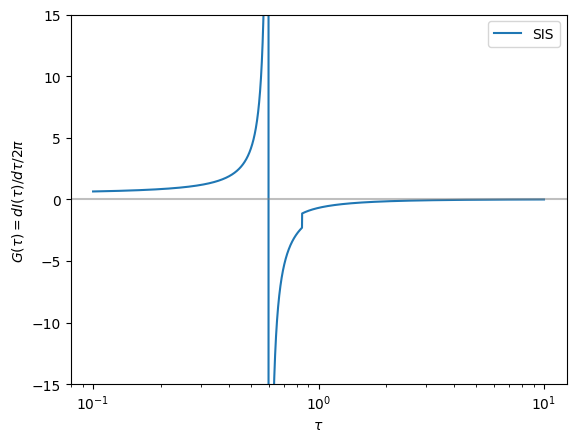

In [8]:
y = 0.3
p_prec = {'eval_mode' : 'exact'}

It_SIS = time_domain_c.It_AnalyticSIS_C(y, p_prec)

## -----------------------------------------------

taus = np.geomspace(1e-1, 10, 10000)
Gts = It_SIS.eval_Gt(taus)

fig, ax = plt.subplots()

ax.plot(taus, Gts, label='SIS')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$G(\tau)=dI(\tau)/d\tau/2\pi$')
ax.set_xscale('log')
ax.set_ylim([-15, 15])
ax.axhline(y=0, c='grey', alpha=0.5)
ax.legend(loc='best');

## Single integral

This method reduces the difraction integral in the time domain, i.e. a 2d integral of a Dirac delta, to a single ordinary integral for axisymmetric lenses. It can handle strong lensing, but it is limited to axisymmetric lenses. 

Strong lensing examples for the CIS and NFW:

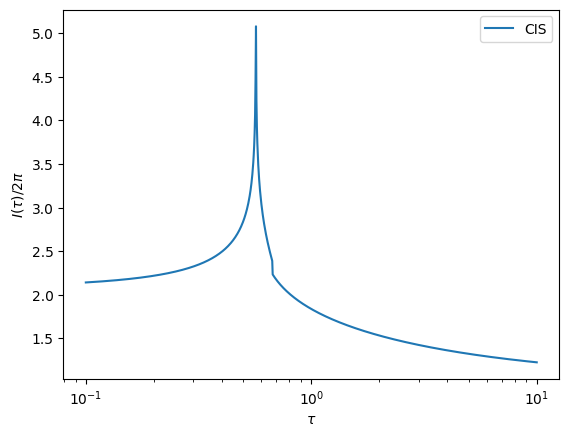

In [9]:
Psi = lenses.Psi_CIS()

y = 0.3
p_prec = {'eval_mode':'exact'}

It = time_domain_c.It_SingleIntegral_C(Psi, y, p_prec)

## ---------------------------------------------------------

taus = np.geomspace(1e-1, 10, 1000)

fig, ax = plt.subplots()

ax.plot(taus, It(taus)/2/np.pi, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.set_xscale('log')
ax.legend(loc='best');

The step function is built-in in the exact mode:

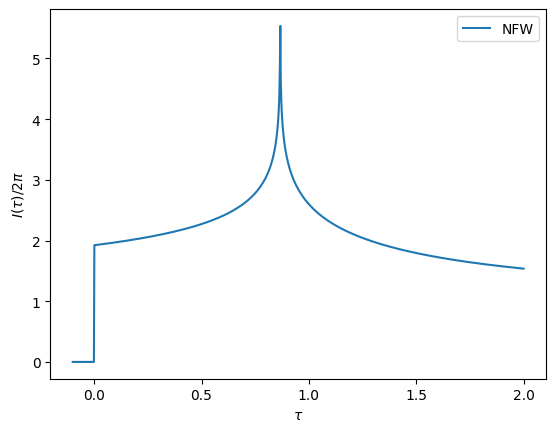

In [10]:
Psi = lenses.Psi_NFW({'xs':0.1})

y = 0.3
p_prec = {'eval_mode':'exact'}

It = time_domain_c.It_SingleIntegral_C(Psi, y, p_prec)

## ---------------------------------------------------------

taus = np.linspace(-0.1, 2, 1000)

fig, ax = plt.subplots()

ax.plot(taus, It(taus)/2/np.pi, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.legend(loc='best');

## Area integral

This method is slow and noisy compared with the others, and its current implementation is very naive. However, it has been included to cross-check the results of the other methods, since it can be equally applied to any lens and it requires minimal extra information. In particular, it is the only method where the computation of the images is not required (only the global minimum is needed).

In [11]:
Psi = lenses.Psi_CIS({'rc':0.1})

y = 0.2
p_prec = {'n_rho' : 20000,
          'tmax' : 3,
          'Nt' : 500}

It = time_domain_c.It_AreaIntegral_C(Psi, y, p_prec)

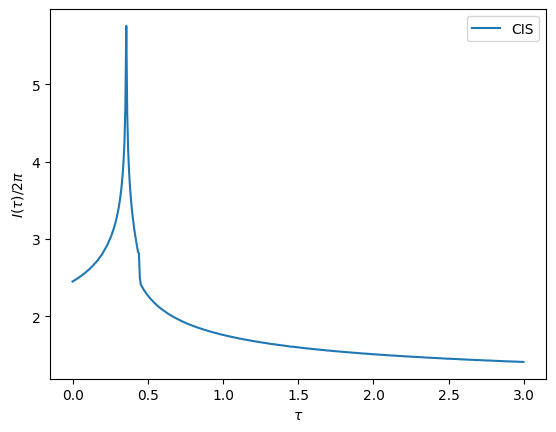

In [12]:
fig, ax = plt.subplots()

ax.plot(It.t_grid, It.It_grid/2/np.pi, label=It.lens.p_phys['name'])

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)/2\pi$')
ax.legend(loc='best');

## Numerical lenses

When the lens is not implemented in C, the code will try to precompute it in a grid, using the Python version, and then read it in C. There is a performance overhead, that can be mitigated reducing the size of the grid, but this feature will (hopefully) increase the flexibility of the code.

In [13]:
Psi = lenses.Psi_SIS()
Psi.p_phys['name'] = 'new SIS'

y = 1.4
p_prec = {'eval_mode' : 'interpolate'}
It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

/home/hector/Documents/repos/glow_public_repo/notebooks/glow/time_domain_c.py:204: TimeDomainWarning: lens 'new SIS' not implemented in C, proceeding numerically
  warnings.warn(message, TimeDomainWarning)


For now, only axisymmetric lenses are allowed.

## Getting contours

The `SingleContour`, `SingleIntegral` and `MultiContour` classes contain a method to output the contours of constant time delay.

In [14]:
# auxiliary function to map times to colors
def color_scheme(ts, cmap='rainbow', log_norm=False):
        if log_norm is True:
            log_tmin = np.log10(ts[0])
            log_tmax = np.log10(ts[-1])
            normalization = (np.log10(ts) - log_tmin)/(log_tmax - log_tmin)
        else:
            normalization = (ts - ts[0])/(ts[-1] - ts[0])

        cm = plt.colormaps.get_cmap(cmap)
        colors = cm(normalization)
    
        return colors

### Single contour

We can obtain an array of contours for a given array of $\tau$ values. We must also specify the number of points in the contour. Each point is obtained integrating the differential equation (not interpolating).

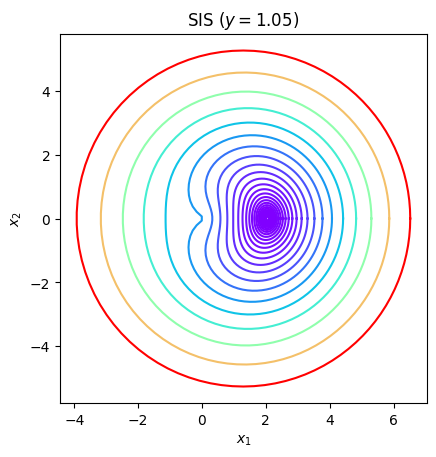

In [15]:
y = 1.05
Psi = lenses.Psi_SIS()
It_std = time_domain_c.It_SingleContour_C(Psi, y, {'method':'standard', 'eval_mode':'exact'})
        
n_points = 100
n_contours = 30
ts = np.geomspace(1e-3, 10, n_contours)
cnts_std = It_std.get_contour(ts, n_points=n_points)

## ------------------------------------------------------------

fig, ax = plt.subplots()
for cnt, color in zip(cnts_std, color_scheme(ts)):
    ax.plot(cnt['x1'], cnt['x2'], c=color)

ax.set_aspect('equal')
ax.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It_std.y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

If the number of points is not specified (or set to be smaller than 1), then the contour contains the accepted points in the computation of $I(\tau)$. This information is useful for debugging. In this method, we can also obtain the contours in terms of $(R, \alpha)$, i.e. the polar coordinates actually used in the integration. Below we also compare with the 'robust' method, where the contours are computed as a parametric representation $R(\sigma)$ and $\alpha(\sigma)$ (the variable $\sigma$ is also stored in the contour dictionary).

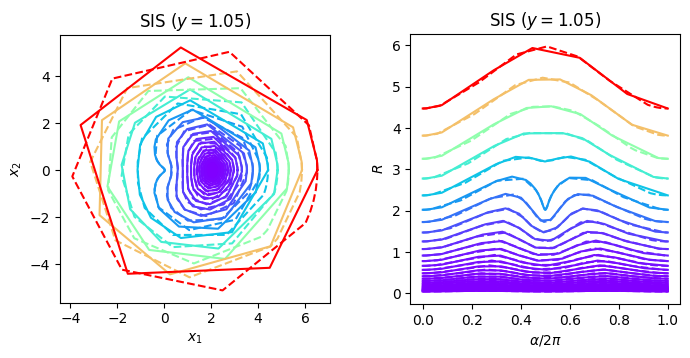

In [16]:
y = 1.05
Psi = lenses.Psi_SIS()
It_std = time_domain_c.It_SingleContour_C(Psi, y, {'method':'standard', 'eval_mode':'exact'})
It_rob = time_domain_c.It_SingleContour_C(Psi, y, {'method':'robust', 'eval_mode':'exact'})

n_contours = 30
ts = np.geomspace(1e-3, 10, n_contours)
cnts_std = It_std.get_contour(ts)
cnts_rob = It_rob.get_contour(ts)

## -----------------------------------------------------

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw={'wspace':0.3})
for cnt1, cnt2, color in zip(cnts_std, cnts_rob, color_scheme(ts)):
    ax.plot(cnt1['x1'], cnt1['x2'], c=color)
    ax.plot(cnt2['x1'], cnt2['x2'], c=color, ls='--')

    ax2.plot(cnt1['alpha']/np.pi/2., cnt1['R'], c=color)
    ax2.plot(cnt2['alpha']/np.pi/2., cnt2['R'], c=color, ls='--')
    
ax.set_aspect('equal')
ax.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It_std.y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax2.set_box_aspect(1)
ax2.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It_std.y))
ax2.set_xlabel('$\\alpha/2\\pi$')
ax2.set_ylabel('$R$');

### Single integral

Even though in this algorithm the contours are irrelevant, they can also be computed. For debugging purposes, the relevant quantities in this method are the minimum an maximum values of $x_1$ at $x_2=0$ for a given contour. These set the upper and lower limits for the radial integral.

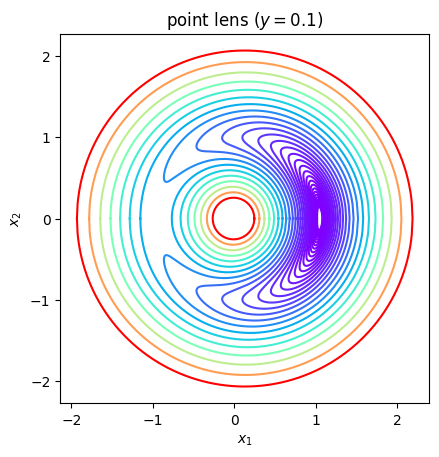

In [17]:
y = 0.1
Psi = lenses.Psi_PointLens()
It_int = time_domain_c.It_SingleIntegral_C(Psi, y, {'eval_mode':'exact'})

n_points = 1000
n_contours = 30
ts = np.geomspace(1e-3, 1, n_contours)
cnts_int = It_int.get_contour(ts, n_points=n_points)

## ------------------------------------------------------------

fig, ax = plt.subplots()
for cnt, color in zip(cnts_int, color_scheme(ts)):
    for x1, x2 in zip(cnt['x1'], cnt['x2']):
        ax.plot(x1, x2, c=color)

ax.set_aspect('equal')
ax.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It_int.y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

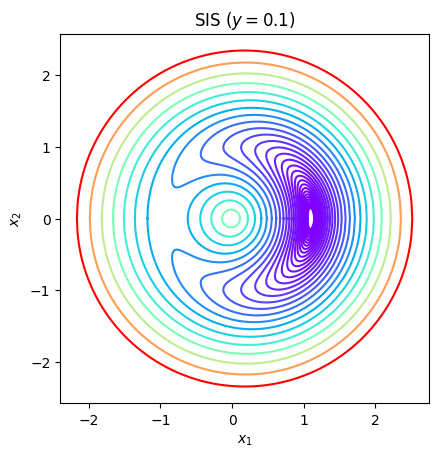

In [18]:
y = 0.1
Psi = lenses.Psi_SIS()
It_int = time_domain_c.It_SingleIntegral_C(Psi, y, {'eval_mode':'exact'})

n_points = 1000
n_contours = 30
ts = np.geomspace(1e-3, 1, n_contours)
cnts_int = It_int.get_contour(ts, n_points=n_points)

## ------------------------------------------------------------

fig, ax = plt.subplots()
for cnt, color in zip(cnts_int, color_scheme(ts)):
    for x1, x2 in zip(cnt['x1'], cnt['x2']):
        ax.plot(x1, x2, c=color)

ax.set_aspect('equal')
ax.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It_int.y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

### Multicontour

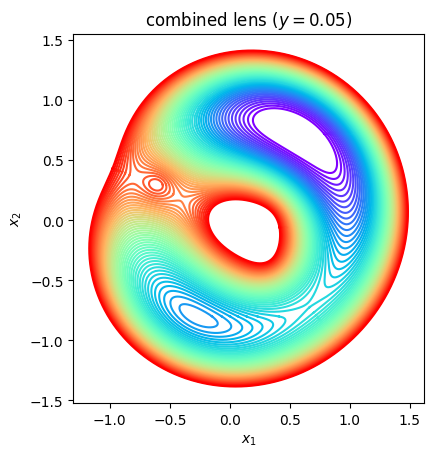

In [19]:
def benchmark_lens():
    # benchmark lens for 2d SL    
    xs = [[0.3, 0], [-0.6, 0.3], [0.3, -0.3], [0, 0]]
    psi0 = 1./len(xs)
    rc = 0.05
    Psis = [lenses.Psi_offcenterCIS({'psi0':psi0, 'rc':rc, 'xc1':x[0], 'xc2':x[1]}) for x in xs]
    Psi = lenses.CombinedLens({'lenses':Psis})
    return Psi

## ------------------------------------------------------------

y = 0.05
Psi = benchmark_lens()
It = time_domain_c.It_MultiContour_C(Psi, y, {'eval_mode':'exact'})

n_points = 2000
n_contours = 60
ts = np.linspace(1e-2, 0.15, n_contours)
cnts = It.get_contour(ts, n_points=n_points)

## ------------------------------------------------------------

fig, ax = plt.subplots()
for cnt, color in zip(cnts, color_scheme(ts)):
    for x1, x2 in zip(cnt['x1'], cnt['x2']):
        ax.plot(x1, x2, c=color)

ax.set_aspect('equal')
ax.set_title('%s $(y=%g)$' % (Psi.p_phys['name'], It.y))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

# Frequency domain

## General purpose F(w)

The main object for the computation of the amplification factor `Fw_FFT_C` is a general purpose algorithm that computes the FFT of $I(\tau)$ to obtain the amplification factor. It uses the new regularization scheme, trying to improve the precision (and speed) of the computation when information about the asymptotic behaviour of the lens is available.

The algorithm first computes the Fourier transform of the regularized $I(\tau)$ and then add to it the analytic FT of the singular contribution. It is always a good idea to plot `Fw_reg` separately from `Fw`, since this is the one that is actually computed numerically.

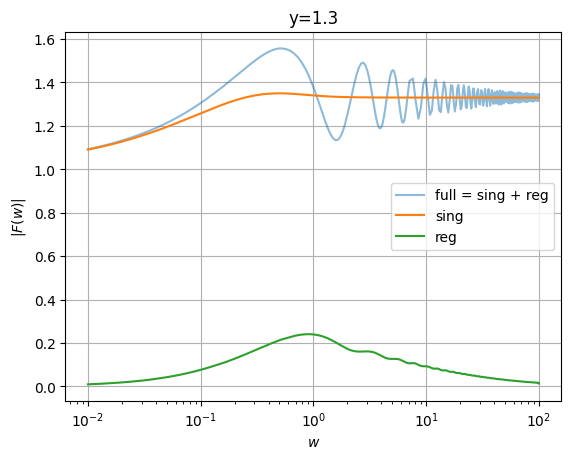

In [20]:
y = 1.3
It = time_domain_c.It_AnalyticSIS_C(y)
Fw = freq_domain_c.Fw_FFT_C(It)

## ----------------------------------------

ws = Fw.w_grid

fig, ax = plt.subplots()
ax.plot(ws, np.abs(Fw(ws)), label='full = sing + reg', alpha=0.5)
ax.plot(ws, np.abs(Fw.eval_Fw_sing(ws)), label='sing')
ax.plot(ws, np.abs(Fw.eval_Fw_reg(ws)), label='reg')
ax.set_xscale('log')
ax.set_xlabel('$w$')
ax.set_ylabel('$|F(w)|$')
ax.legend()
ax.set_title("y=%g" % y)
ax.grid()

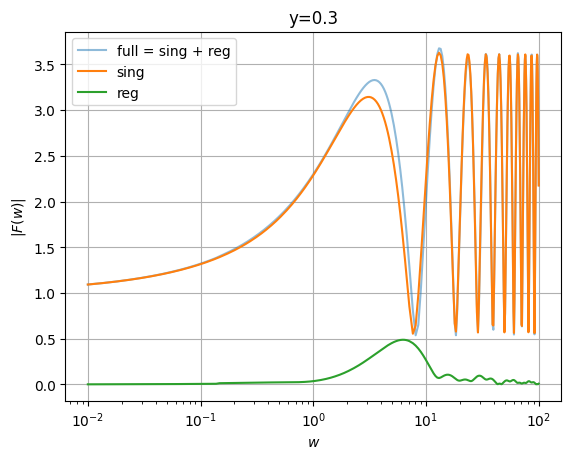

In [21]:
y = 0.3
It = time_domain_c.It_AnalyticSIS_C(y)
Fw = freq_domain_c.Fw_FFT_C(It)

## ----------------------------------------

ws = Fw.w_grid

fig, ax = plt.subplots()
ax.plot(ws, np.abs(Fw(ws)), label='full = sing + reg', alpha=0.5)
ax.plot(ws, np.abs(Fw.eval_Fw_sing(ws)), label='sing')
ax.plot(ws, np.abs(Fw.eval_Fw_reg(ws)), label='reg')
ax.set_xscale('log')
ax.set_xlabel('$w$')
ax.set_ylabel('$|F(w)|$')
ax.set_title("y=%g" % y)
ax.legend()
ax.grid()

It is also advisable to plot the regularized version of $I(\tau)$, in order to see what is the object actually dealing with. 

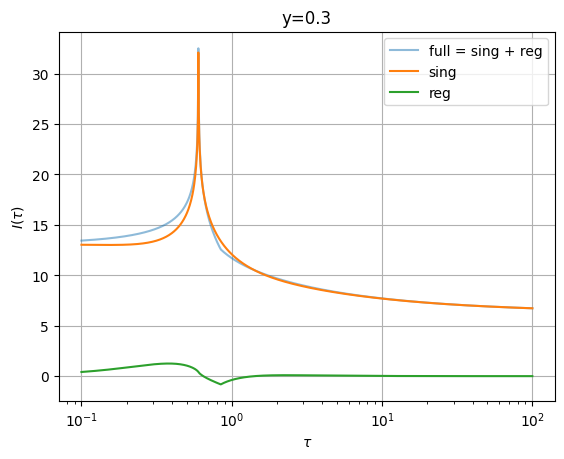

In [22]:
y = 0.3
It = time_domain_c.It_AnalyticSIS_C(y)
Fw = freq_domain_c.Fw_FFT_C(It)

## ----------------------------------------

ts = np.geomspace(1e-1, 1e2, 1000)

fig, ax = plt.subplots()
ax.plot(ts, Fw.It(ts), label='full = sing + reg', alpha=0.5)
ax.plot(ts, Fw.eval_It_sing(ts), label='sing')
ax.plot(ts, Fw.eval_It_reg(ts), label='reg')
ax.set_xscale('log')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)$')
ax.set_title("y=%g" % y)
ax.legend()
ax.grid()

## Analytic point lens

We also implemented an extremely fast version of the analytic amplification factor for the point lens. The accuracy is calibrated to $10^{-5}$.

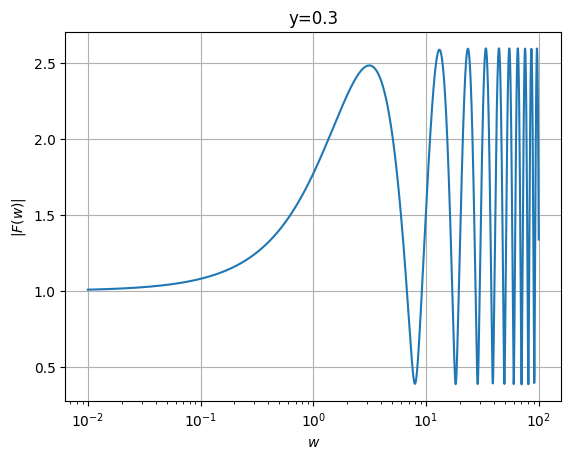

In [23]:
y = 0.3
Fw = freq_domain_c.Fw_AnalyticPointLens_C(y)

## ----------------------------------------

ws = np.geomspace(1e-2, 1e2, 2000)

fig, ax = plt.subplots()
ax.plot(ws, np.abs(Fw(ws)))
ax.set_xscale('log')
ax.set_xlabel('$w$')
ax.set_ylabel('$|F(w)|$')
ax.set_title("y=%g" % y)
ax.grid()

## Semianalytic SIS

This is the semi-analytic computation of the amplification factor for the SIS.

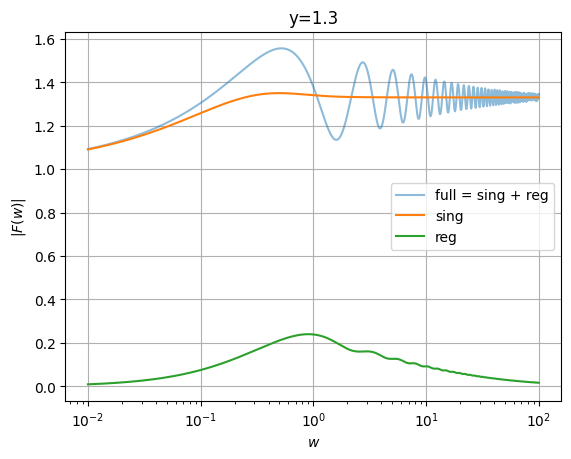

In [24]:
y = 1.3
Fw = freq_domain_c.Fw_SemiAnalyticSIS_C(y)

## ----------------------------------------

ws = np.geomspace(1e-2, 1e2, 1000)

fig, ax = plt.subplots()
ax.plot(ws, np.abs(Fw.eval_Fw(ws)), label='full = sing + reg', alpha=0.5)
ax.plot(ws, np.abs(Fw.eval_Fw_sing(ws)), label='sing')
ax.plot(ws, np.abs(Fw.eval_Fw_reg(ws)), label='reg')
ax.set_xscale('log')
ax.set_xlabel('$w$')
ax.set_ylabel('$|F(w)|$')
ax.legend()
ax.set_title("y=%g" % y)
ax.grid()

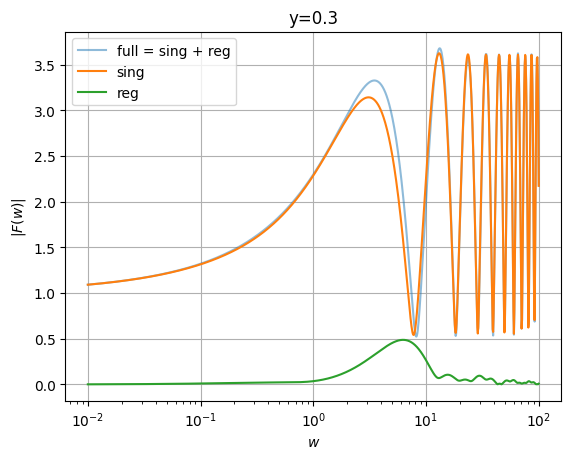

In [25]:
y = 0.3
Fw = freq_domain_c.Fw_SemiAnalyticSIS_C(y)

## ----------------------------------------

ws = np.geomspace(1e-2, 1e2, 1000)

fig, ax = plt.subplots()
ax.plot(ws, np.abs(Fw.eval_Fw(ws)), label='full = sing + reg', alpha=0.5)
ax.plot(ws, np.abs(Fw.eval_Fw_sing(ws)), label='sing')
ax.plot(ws, np.abs(Fw.eval_Fw_reg(ws)), label='reg')
ax.set_xscale('log')
ax.set_xlabel('$w$')
ax.set_ylabel('$|F(w)|$')
ax.set_title("y=%g" % y)
ax.legend()
ax.grid()

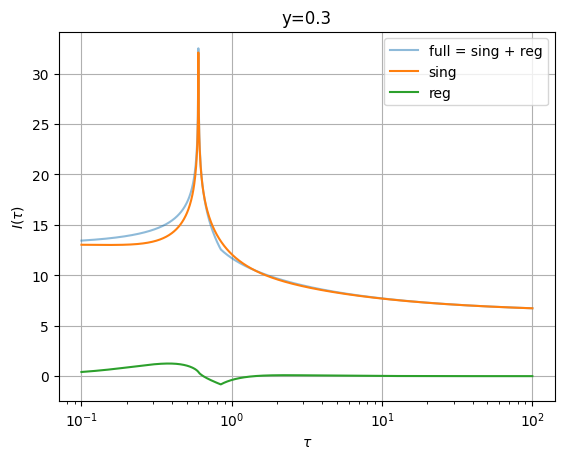

In [26]:
y = 0.3
Fw = freq_domain_c.Fw_SemiAnalyticSIS_C(y)

## ----------------------------------------

ts = np.geomspace(1e-1, 1e2, 1000)

fig, ax = plt.subplots()
ax.plot(ts, Fw.It.eval_It(ts), label='full = sing + reg', alpha=0.5)
ax.plot(ts, Fw.eval_It_sing(ts), label='sing')
ax.plot(ts, Fw.eval_It_reg(ts), label='reg')
ax.set_xscale('log')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$I(\tau)$')
ax.set_title("y=%g" % y)
ax.legend()
ax.grid()

# Miscellanea

## Internal information and debugging

### Python

All the objects defined in the Python modules share a common structure. They only take as parameters either another object, a `p_phys` or a `p_prec` dictionary. This make it easy to display the internal information of each object. All of them ship with a `display_info()` method, that is also a good remainder of the allowed input parameters.

In [27]:
Psi = lenses.Psi_SIS()
Psi.display_info()

	////////////////////////////
	///   Lens information   ///
	////////////////////////////

 * Name: SIS

 * Physical parameters:
   ** psi0 = 1



In [28]:
It = time_domain_c.It_SingleContour_C(Psi, y=1.2)
It.display_info()

	////////////////////////////
	///   I(t) information   ///
	////////////////////////////

 * Method: single contour (C code)

 * Impact parameter y = 1.2

 * Precision parameters:
   ** Nt = 5000
   ** tmin = 0.01
   ** tmax = 1000000.0
   ** eval_mode = interpolate
   ** sampling = log
   ** interp_fill_value = None
   ** interp_kind = linear
   ** oversampling_n = 10
   ** oversampling_tmin = 0.1
   ** oversampling_tmax = 10.0
   ** lens_file_xmin = 1e-07
   ** lens_file_xmax = 10000000.0
   ** lens_file_Nx = 10000
   ** lens_file_fname = wrapper/glow_lib/external/tmp
   ** C_prec = {}
   ** method = standard
   ** parallel = True

 * Lens: SIS



In [29]:
Fw = freq_domain_c.Fw_FFT_C(It)
Fw.display_info()

	////////////////////////////
	///   F(w) information   ///
	////////////////////////////

 * Method: FFT (new regularization, full C version)

 * Precision parameters:
   ** interp_fill_value = None
   ** interp_kind = linear
   ** reg_stage = 2
   ** C_prec = {}
   ** wmin = 0.01
   ** wmax = 100.0
   ** window_transition = 0.2
   ** smallest_tau_max = 10
   ** N_above_discard = 6
   ** N_below_discard = 4
   ** N_keep = 2
   ** eval_mode = interpolate
   ** FFT method = multigrid
   ** parallel = True

 * Lens: SIS
 * Time domain method: single contour (C code)
 * Impact parameter: y = 1.2



The time-domain integral can also show the information about the images found

In [30]:
It = time_domain_c.It_SingleContour_C(Psi, y=1.2)
It.display_images()

	////////////////////////////
	///        Images        ///
	////////////////////////////

 * Lens: SIS  (y = 1.2)

 * Image 0  (min):
   **   t = -1.700000e+00
   ** tau = 0.000000e+00
   **   x = (2.200000e+00, -5.071117e-09)
   **  mu = 1.833333e+00



In [31]:
It = time_domain_c.It_SingleIntegral_C(Psi, y=0.2)
It.display_images()

	////////////////////////////
	///        Images        ///
	////////////////////////////

 * Lens: SIS  (y = 0.2)

 * Image 0  (min):
   **   t = -7.000000e-01
   ** tau = 0.000000e+00
   **   x = (1.200000e+00, 0.000000e+00)
   **  mu = 6.000000e+00

 * Image 1  (saddle):
   **   t = -3.000000e-01
   ** tau = 4.000000e-01
   **   x = (-8.000000e-01, 0.000000e+00)
   **  mu = 4.000000e+00

 * Image 2  (sing/cusp max):
   **   t = 2.000000e-02
   ** tau = 7.200000e-01
   **   x = (0.000000e+00, 0.000000e+00)
   **  mu = 6.971905e-28



Another feature, especially useful for debugging, is the ability to print the tree of calls needed to replicate a given object:

In [32]:
print(Psi)

p_phys = {'name': 'SIS', 'psi0': 1}
p_prec = {}
Psi = lenses.Psi_SIS(p_phys, p_prec)


In [33]:
print(It)

p_phys = {'name': 'SIS', 'psi0': 1}
p_prec = {}
Psi = lenses.Psi_SIS(p_phys, p_prec)

y = 0.2
p_prec = {'Nt': 5000, 'tmin': 0.01, 'tmax': 1000000.0, 'eval_mode': 'interpolate', 'sampling': 'log', 'interp_fill_value': None, 'interp_kind': 'linear', 'oversampling_n': 10, 'oversampling_tmin': 0.1, 'oversampling_tmax': 10.0, 'lens_file_xmin': 1e-07, 'lens_file_xmax': 10000000.0, 'lens_file_Nx': 10000, 'lens_file_fname': 'wrapper/glow_lib/external/tmp', 'C_prec': {}, 'parallel': True, 'method': 'qag15'}
It = time_domain_c.It_SingleIntegral_C(Psi, y, p_prec)


In [34]:
print(Fw)

p_phys = {'name': 'SIS', 'psi0': 1}
p_prec = {}
Psi = lenses.Psi_SIS(p_phys, p_prec)

y = 1.2
p_prec = {'Nt': 5000, 'tmin': 0.01, 'tmax': 1000000.0, 'eval_mode': 'interpolate', 'sampling': 'log', 'interp_fill_value': None, 'interp_kind': 'linear', 'oversampling_n': 10, 'oversampling_tmin': 0.1, 'oversampling_tmax': 10.0, 'lens_file_xmin': 1e-07, 'lens_file_xmax': 10000000.0, 'lens_file_Nx': 10000, 'lens_file_fname': 'wrapper/glow_lib/external/tmp', 'C_prec': {}, 'method': 'standard', 'parallel': True}
It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

p_prec = {'interp_fill_value': None, 'interp_kind': 'linear', 'reg_stage': 2, 'C_prec': {}, 'wmin': 0.01, 'wmax': 100.0, 'window_transition': 0.2, 'smallest_tau_max': 10, 'N_above_discard': 6, 'N_below_discard': 4, 'N_keep': 2, 'eval_mode': 'interpolate', 'FFT method': 'multigrid', 'parallel': True}
Fw = freq_domain_c.Fw_FFT_C(It, p_prec)


In this simple example it is pretty straightforward, but this feature is useful for debugging the code when the amplification factor has been generated in the middle of a more complicated script, e.g. when we use a random distribution of lenses or a lens generated by a different piece of code.

### C precision parameters

Most of the precision parameters in the C code can be accessed from Python. After defining the main object, the current precision parameters can be visualized with the `display_Cprec` method (including options for non-numerical parameters)

In [35]:
It = time_domain_c.It_AnalyticSIS_C(y=1.2)
#It.display_Cprec()   # long output

These parameters can be modified through an entry in `p_prec`

In [36]:
C_prec = {'ro_issameCP_dist' : 2e-5, \
          'sc_intContourStd' : {'type' : 'rkf45', 'epsabs' : 1e-6}}
Psi = lenses.Psi_SIS()
It = time_domain_c.It_SingleContour_C(Psi, y=1.2, p_prec={'C_prec' : C_prec})

If needed, the precision parameters of the current session can also be retrieved in dictionary form

In [37]:
full_C_prec = It.get_Cprec()

## A more complex example: $n$ SISs

First, we define a couple of functions that will prove handy

In [38]:
def distribute_centers(n, R=1, seed=None):
    
    if(seed is None):
        seed = np.random.randint(0, 1e7)
        print("Seed:", seed)    
    np.random.seed(seed)
    
    Rs = R*np.sqrt(np.random.random_sample(n))
    ths = 2*np.pi*np.random.random_sample(n)
    
    x1 = Rs*np.cos(ths)
    x2 = Rs*np.sin(ths)
    
    x1CM = np.sum(x1)/n
    x2CM = np.sum(x2)/n
    
    x1 -= x1CM
    x2 -= x2CM
    
    return x1, x2

def create_lens(n, R, seed=None):
    psi0 = 1./n
    xc1s, xc2s = distribute_centers(n, R, seed=seed)
    
    p_phys = {'lenses' : []}
    for xc1, xc2 in zip(xc1s, xc2s):
        sub_p_phys = {'psi0' : psi0, 'xc1' : xc1, 'xc2' : xc2}
        Psi = lenses.Psi_offcenterSIS(sub_p_phys)
        p_phys['lenses'].append(Psi)

    return lenses.CombinedLens(p_phys)

def plot_It(Psi, y, SIS=False, CIS=False, rc=0.1):
    p_prec = {'eval_mode':'exact', 'C_prec':{'no_warnings':1}}
    It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

    taus = np.geomspace(1e-1, 50, 1000)

    fig, ax = plt.subplots()
    ax.plot(taus, It.eval_It(taus)/2/np.pi, label='%d SIS' % len(Psi.p_phys['lenses']))
    ax.set_xscale('log')
    
    It_SIS = None
    if SIS is True:
        It_SIS = time_domain_c.It_AnalyticSIS_C(y, {'eval_mode':'exact'})
        ax.plot(taus, It_SIS.eval_It(taus)/2/np.pi, label='SIS')
    
    It_CIS = None
    if CIS is True:
        Psi_CIS = lenses.Psi_CIS({'rc':rc})
        It_CIS = time_domain_c.It_SingleContour_C(Psi_CIS, y, {'eval_mode':'exact'})
        ax.plot(taus, It_CIS.eval_It(taus)/2/np.pi, label='CIS')
    
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel(r'$I(\tau)/2\pi$')
    ax.set_xlim([taus[0], taus[-1]])
    ax.legend(loc='best')
    
def plot_Gt(Psi, y, SIS=False, CIS=False, rc=0.1):
    p_prec = {'eval_mode':'exact', 'C_prec':{'no_warnings':1}}
    It = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

    dt = 1e-3
    taus = np.geomspace(1e-1, 50, 1000)
    
    fig, ax = plt.subplots()
    ax.plot(taus, It.eval_Gt(taus, dt=dt), label='%d SIS' % len(Psi.p_phys['lenses']), c='C0')
    ax.set_xscale('log')
    
    It_SIS = None
    if SIS is True:
        It_SIS = time_domain_c.It_AnalyticSIS_C(y, {'eval_mode':'exact'})
        ax.plot(taus, It_SIS.eval_Gt(taus, dt=dt), label='SIS', c='C1')
    
    It_CIS = None
    if CIS is True:
        Psi_CIS = lenses.Psi_CIS({'rc':rc})
        It_CIS = time_domain_c.It_SingleContour_C(Psi_CIS, y, {'eval_mode':'exact'})
        ax.plot(taus, It_CIS.eval_Gt(taus, dt=dt), label='CIS', c='C2')
    
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel(r'$G(\tau)$')
    ax.set_xlim([taus[0], taus[-1]])
    ax.legend(loc='best')

In [39]:
It.display_info()

	////////////////////////////
	///   I(t) information   ///
	////////////////////////////

 * Method: single contour (C code)

 * Impact parameter y = 1.2

 * Precision parameters:
   ** Nt = 5000
   ** tmin = 0.01
   ** tmax = 1000000.0
   ** eval_mode = interpolate
   ** sampling = log
   ** interp_fill_value = None
   ** interp_kind = linear
   ** oversampling_n = 10
   ** oversampling_tmin = 0.1
   ** oversampling_tmax = 10.0
   ** lens_file_xmin = 1e-07
   ** lens_file_xmax = 10000000.0
   ** lens_file_Nx = 10000
   ** lens_file_fname = wrapper/glow_lib/external/tmp
   ** C_prec = {'ro_issameCP_dist': 2e-05, 'sc_intContourStd': {'epsabs': 1e-06, 'id': 0}}
   ** method = standard
   ** parallel = True

 * Lens: SIS



Now, we will create a set of (`n_sublenses`) SIS randomly distributed inside a sphere of radius (`R`). The center of mass position and the total lens mass are fixed.

In [40]:
n_sublenses = 3
R = 1

Psi = create_lens(n=n_sublenses, R=R, seed=None)

Seed: 987059


We can compare this composed lens with a SIS or a CIS of the same mass (situated at the center of mass of the lens distribution)

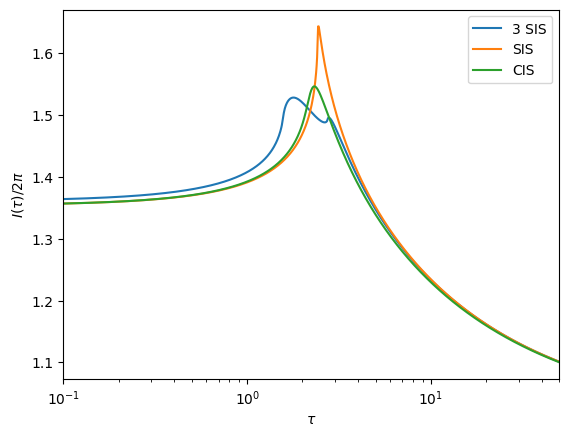

In [41]:
plot_It(Psi, y=1.2, SIS=True, CIS=True)

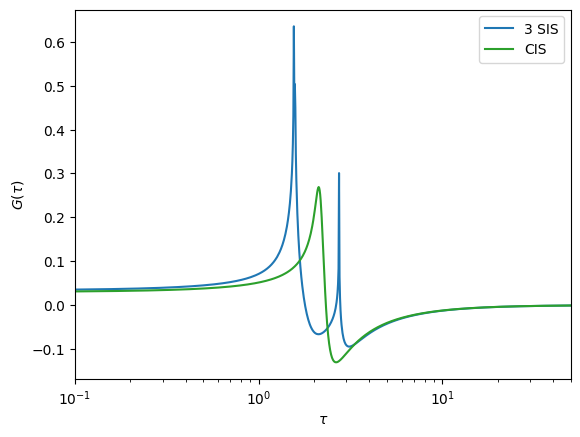

In [42]:
plot_Gt(Psi, y=1.2, SIS=False, CIS=True)

We can also compare the effects in the amplification factor. First we must compute the time-domain integral in a wide temporal range, as usual. (Note: the plot above was computed using the `p_prec['eval_method']='exact'` option to compute it at any tau requested, now we need a grid so we must use `'interpolate'`, which is the default)

In [43]:
y = 1.2
p_prec = {'tmin':1e-2, 'tmax':1e8, 'Nt':5000, 'sampling':'log', 'C_prec':{'no_warnings':1}}

It_MultiSIS = time_domain_c.It_SingleContour_C(Psi, y, p_prec)

It_SIS = time_domain_c.It_AnalyticSIS_C(y, p_prec)

Psi_CIS = lenses.Psi_CIS({'rc':0.1})
It_CIS = time_domain_c.It_SingleContour_C(Psi_CIS, y, p_prec)

Next, we compute the amplification factors

In [44]:
Fw_MultiSIS = freq_domain_c.Fw_FFT_C(It_MultiSIS, {'interp_kind':'cubic'})
Fw_SIS = freq_domain_c.Fw_FFT_C(It_SIS, {'interp_kind':'cubic'})
Fw_CIS = freq_domain_c.Fw_FFT_C(It_CIS, {'interp_kind':'cubic'})

and plot them

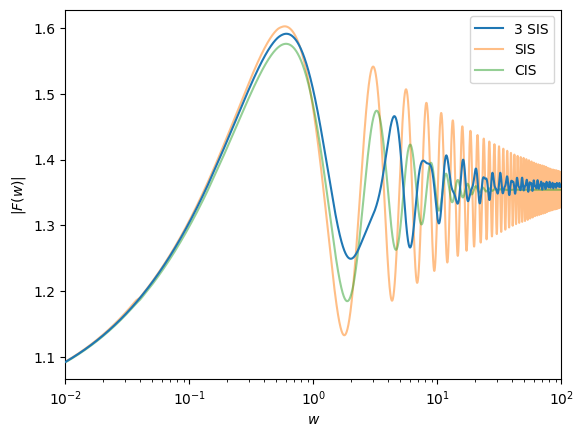

In [45]:
fig, ax = plt.subplots()

ws = np.geomspace(1e-2, 1e2, 5000)

ax.plot(ws, np.abs(Fw_MultiSIS(ws)), zorder=10, label='%d SIS' % len(Psi.p_phys['lenses']))
ax.plot(ws, np.abs(Fw_SIS(ws)), alpha=0.5, label='SIS')
ax.plot(ws, np.abs(Fw_CIS(ws)), alpha=0.5, label='CIS')

ax.set_xlim([ws[0], ws[-1]])
ax.set_xscale('log')
ax.set_ylabel('$|F(w)|$')
ax.set_xlabel('$w$')
ax.legend(loc='best');

## Testing performance

### Analytic SIS

In [46]:
y = 0.3
psi0 = 1

tau_ini = 0.8
taus = np.geomspace(1e-2, 10, 1000)

Performance for a single point, numpy arrays and numpy arrays in parallel

In [47]:
%timeit wrapper.pyIt_SIS(tau_ini, y, psi0)
%timeit wrapper.pyIt_SIS(taus, y, psi0, parallel=False)
%timeit wrapper.pyIt_SIS(taus, y, psi0)

9.53 µs ± 341 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
996 µs ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
531 µs ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Single contour

Benchmark values (RK(8,9) integrator with tol=1e-5, compilation with `-Ofast`)

In [48]:
y = 1.1
psi0 = 1
x1_min = psi0 + y
x2_min = 0

Psi = lenses.Psi_SIS({'psi0':psi0})

tau_ini = 0.8
taus = np.geomspace(0.1, 100, 1000)

Performance for a single point, numpy arrays and numpy arrays in parallel

In [49]:
%timeit wrapper.pyContour(tau_ini, x1_min, x2_min, y, Psi)
%timeit wrapper.pyContour(taus, x1_min, x2_min, y, Psi, parallel=False)
%timeit wrapper.pyContour(taus, x1_min, x2_min, y, Psi)

36.3 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
21.6 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Same but now with the `'robust'` method (i.e. parametric contours)

In [50]:
%timeit wrapper.pyContour(tau_ini, x1_min, x2_min, y, Psi, method='robust')
%timeit wrapper.pyContour(taus, x1_min, x2_min, y, Psi, parallel=False, method='robust')
%timeit wrapper.pyContour(taus, x1_min, x2_min, y, Psi, method='robust')

64.4 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
59.8 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.6 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can compare it with the exact result

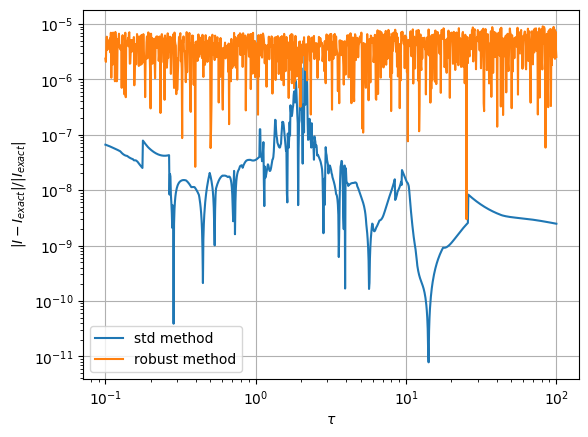

In [51]:
Is = wrapper.pyContour(taus, x1_min, x2_min, y, Psi)
Is2 = wrapper.pyContour(taus, x1_min, x2_min, y, Psi, method='robust')
It_exact = wrapper.pyIt_SIS(taus, y, psi0)

fig, ax = plt.subplots()
ax.plot(taus, np.abs(Is-It_exact)/It_exact, label='std method')
ax.plot(taus, np.abs(Is2-It_exact)/It_exact, label='robust method')
ax.set_xlabel('$\\tau$')
ax.set_ylabel('$|I-I_{exact}|/|I_{exact}|$')
ax.legend()
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')

### Single integral

Benchmark values: `qags` integrator with rtol=1e-4, atol=0, sub_int_limit=1000, compilation with `-Ofast`)

In [52]:
y = 1.3

tau_ini = 0.8
taus = np.geomspace(1e-2, 10, 1000)

Psi = lenses.Psi_SIS()

# extract p_crits first
It = time_domain_c.It_SingleIntegral_C(Psi, y, {'eval_mode':'exact'})
p_crits = It.p_crits

Performance for a single point, numpy arrays and numpy arrays in parallel

In [53]:
%timeit wrapper.pySingleIntegral(tau_ini, y, Psi, p_crits, method='qag15')
%timeit wrapper.pySingleIntegral(taus, y, Psi, p_crits, method='qag15', parallel=False)
%timeit wrapper.pySingleIntegral(taus, y, Psi, p_crits, method='qag15')

11.4 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.56 ms ± 6.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
868 µs ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can compare it with the exact result

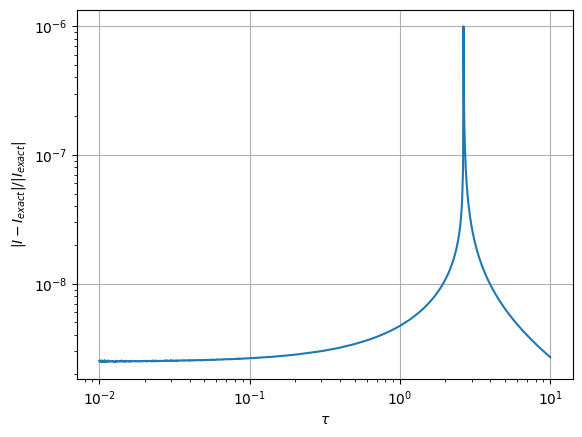

In [54]:
Is = wrapper.pySingleIntegral(taus, y, Psi, p_crits, method='direct')
It_exact = wrapper.pyIt_SIS(taus, y, 1)

fig, ax = plt.subplots()
ax.plot(taus, np.abs(Is-It_exact)/It_exact)
ax.grid()
ax.set_xlabel('$\\tau$')
ax.set_ylabel('$|I-I_{exact}|/|I_{exact}|$')
ax.set_xscale('log')
ax.set_yscale('log')

### Semianalytic SIS

Semi-analytical formula for the SIS

In [55]:
ws = np.geomspace(1e-2, 1e2, 1000)

Strong and weak lensing tests. The `'direct'` method usually outperforms the default `'osc'` method, but it cannot be used for high frequencies.

In [56]:
y = 0.3
Fw1 = freq_domain_c.Fw_SemiAnalyticSIS_C(y)
Fw2 = freq_domain_c.Fw_SemiAnalyticSIS_C(y, {'method':'direct'})

%timeit Fw1.eval_Fw(ws)
%timeit Fw2.eval_Fw(ws)

4.33 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.18 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
y = 1.3
Fw1 = freq_domain_c.Fw_SemiAnalyticSIS_C(y)
Fw2 = freq_domain_c.Fw_SemiAnalyticSIS_C(y, {'method':'direct'})

%timeit Fw1.eval_Fw(ws)
%timeit Fw2.eval_Fw(ws)

18.6 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.5 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### General F(w)

Weak-lensing speed

In [58]:
y = 1.3
It = time_domain_c.It_AnalyticSIS_C(y, {'Nt':5000})

%timeit Fw = freq_domain_c.Fw_FFT_C(It)

1.26 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Strong-lensing speed

In [59]:
y = 0.3
It = time_domain_c.It_AnalyticSIS_C(y, {'Nt':5000})

%timeit Fw = freq_domain_c.Fw_FFT_C(It)

1.53 ms ± 5.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Weak-lensing precision

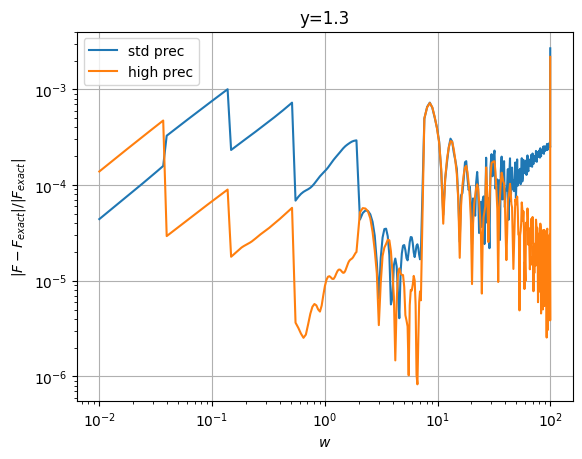

In [60]:
y = 1.3

It_std = time_domain_c.It_AnalyticSIS_C(y)
Fw_std = freq_domain_c.Fw_FFT_C(It_std)

It_high = time_domain_c.It_AnalyticSIS_C(y, {'sampling':'oversampling'})
Fw_high = freq_domain_c.Fw_FFT_C(It_high, p_prec={'N_above_discard':8})

Fw_exact = freq_domain_c.Fw_SemiAnalyticSIS_C(y)

Fws_std  = Fw_std.Fw_grid
Fws_high = Fw_high.Fw_grid
Fws_std_exact  = Fw_exact.eval_Fw(Fw_std.w_grid)
Fws_high_exact = Fw_exact.eval_Fw(Fw_high.w_grid)

fig, ax = plt.subplots()
ax.plot(Fw_std.w_grid, np.abs(Fws_std-Fws_std_exact)/np.abs(Fws_std_exact), label='std prec')
ax.plot(Fw_high.w_grid, np.abs(Fws_high-Fws_high_exact)/np.abs(Fws_high_exact), label='high prec')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('y=%g' % y)
ax.set_xlabel('$w$')
ax.set_ylabel('$|F-F_{exact}|/|F_{exact}|$')
ax.grid()

Strong-lensing precision

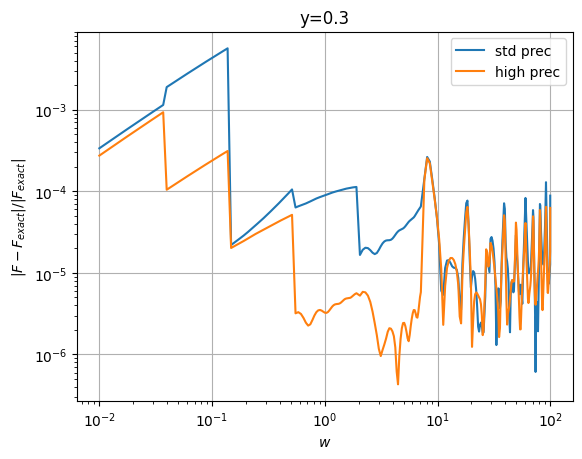

In [61]:
y = 0.3

It_std = time_domain_c.It_AnalyticSIS_C(y)
Fw_std = freq_domain_c.Fw_FFT_C(It_std)

It_high = time_domain_c.It_AnalyticSIS_C(y, {'sampling':'oversampling'})
Fw_high = freq_domain_c.Fw_FFT_C(It_high, p_prec={'N_above_discard':8})

Fw_exact = freq_domain_c.Fw_SemiAnalyticSIS_C(y)

Fws_std  = Fw_std.Fw_grid
Fws_high = Fw_high.Fw_grid
Fws_std_exact  = Fw_exact.eval_Fw(Fw_std.w_grid)
Fws_high_exact = Fw_exact.eval_Fw(Fw_high.w_grid)

fig, ax = plt.subplots()
ax.plot(Fw_std.w_grid, np.abs(Fws_std-Fws_std_exact)/np.abs(Fws_std_exact), label='std prec')
ax.plot(Fw_high.w_grid, np.abs(Fws_high-Fws_high_exact)/np.abs(Fws_high_exact), label='high prec')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('y=%g' % y)
ax.set_xlabel('$w$')
ax.set_ylabel('$|F-F_{exact}|/|F_{exact}|$')
ax.grid()